# WHITE PAPER- CODE

# BRENT CRUDE OIL PRICE FORECASTING

In [281]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import  rmse
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
warnings.filterwarnings('ignore')

In [282]:
import math

In [283]:
#Reading the data
crude = pd.read_csv('C:\\Users\\Nikitha Reddy\\Downloads\\MCOILBRENTEU.csv', 
                   parse_dates=['DATE'])
crude = crude.set_index('DATE')

crude.head()

,MCOILBRENTEU
DATE,
1987-05-01,18.58
1987-06-01,18.86
1987-07-01,19.86
1987-08-01,18.98
1987-09-01,18.31


In [284]:
crude.count()

MCOILBRENTEU    425
dtype: int64

<AxesSubplot:xlabel='DATE'>

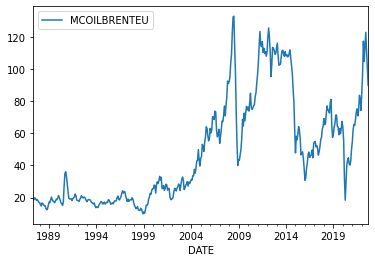

In [285]:
crude.plot()

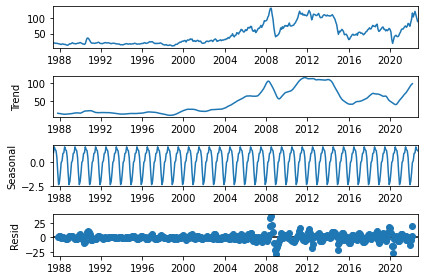

In [286]:
# Components of the Time series

decomposed = seasonal_decompose(crude)
decomposed.plot();
plt.show()

In [287]:
# Making structure ready for time series analysis
crude=crude.groupby('DATE').sum()
crude.head()

,MCOILBRENTEU
DATE,
1987-05-01,18.58
1987-06-01,18.86
1987-07-01,19.86
1987-08-01,18.98
1987-09-01,18.31


In [288]:
# Stationarity test
#ADF Test
series = crude.loc[:, 'MCOILBRENTEU'].values
result = adfuller(series, autolag='AIC')
dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

Test Statistic                  -2.224891
p-value                          0.197336
Lags Used                        1.000000
Number of Observations Used    423.000000
Critical Value (1%)             -3.445904
Critical Value (5%)             -2.868397
Critical Value (10%)            -2.570423
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary


In [289]:
#KPSS Test
from statsmodels.tsa.stattools import kpss
kpsstest = kpss(series, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)


Test Statistic            2.176572
p-value                   0.010000
#Lags Used               12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


Here we observe that in ADF test we fail to reject null hypothesis and say that time series is sationary. And in KPSS test we say that we reject null hypothesis and tell time series is stationary. So we need to apply differencing to make the time series stationary.

<AxesSubplot:xlabel='DATE'>

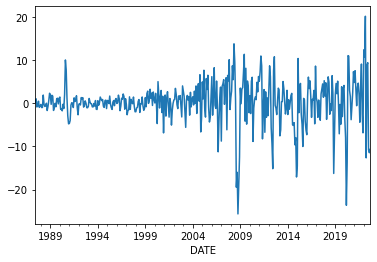

In [290]:
# Differencing the series first order differencing to make it stationary
crude['diff']= crude['MCOILBRENTEU'].diff(periods=1)
crude = crude.dropna() # Removing null values

crude['diff'].plot()

In [291]:
# Checkign the stationary of the difference series
series = crude.loc[:, 'diff'].values
result = adfuller(series, autolag='AIC')
dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in result[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

Test Statistic                -9.402318e+00
p-value                        6.140428e-16
Lags Used                      5.000000e+00
Number of Observations Used    4.180000e+02
Critical Value (1%)           -3.446091e+00
Critical Value (5%)           -2.868479e+00
Critical Value (10%)          -2.570466e+00
dtype: float64
Reject Ho - Time Series is Stationary


In [292]:
#KPSS Test
from statsmodels.tsa.stattools import kpss
kpsstest = kpss(series, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print (kpss_output)

Test Statistic           0.033957
p-value                  0.100000
#Lags Used               4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


Now we can observe that in both the tests we say time series is stationary. In ADF p<0.05 so we reject null hypothesis and in KPSS p>0.05 so we accept null hypothesis and tell time series is stationary.

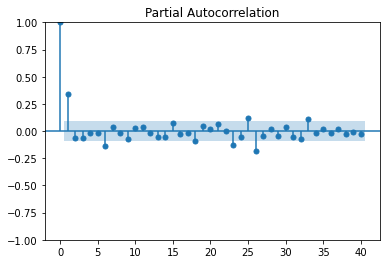

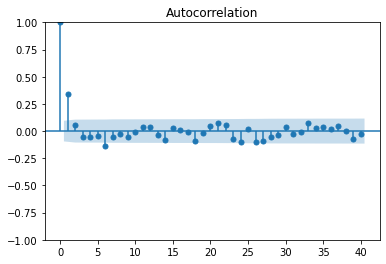

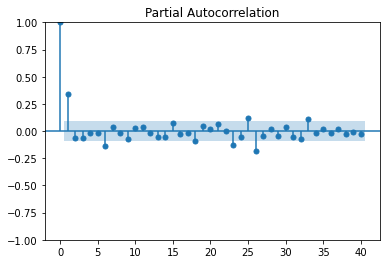

In [293]:
plot_acf(crude['diff'], lags=40)
plot_pacf(crude['diff'], lags=40)

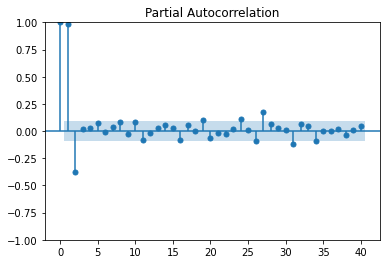

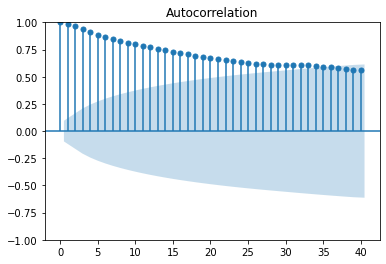

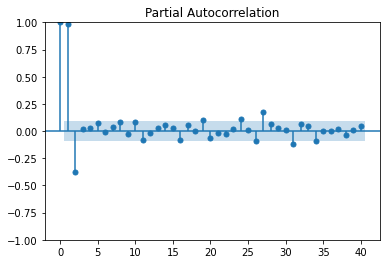

In [294]:
plot_acf(crude['MCOILBRENTEU'], lags=40)
plot_pacf(crude['MCOILBRENTEU'], lags=40)

We observe the ACF and PACF on the main series and not the differeciated series. Here we see a pattern in ACF and PACF has lag values of 2. Hence p=2 and q=0 in seasonal

In [295]:
# take the original series and not the differenced one for forecasting
# Deleting the diff column

crude.drop(['diff'], axis=1, inplace=True)

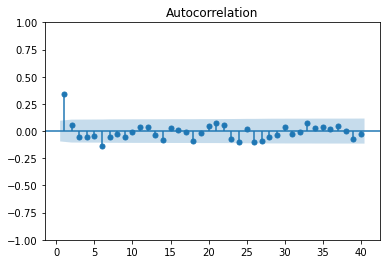

In [296]:
plot_acf(crude.diff(1).dropna(), lags=40, zero=False); 

plt.show()
# seasonality in the data of 12 months

<AxesSubplot:xlabel='DATE'>

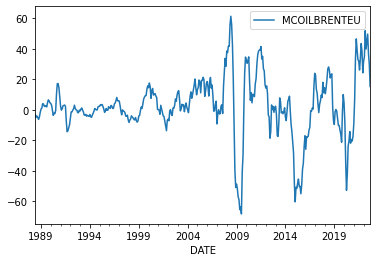

In [297]:
# seasonal Differencing
crude_dif_12 = crude.diff(12).dropna() #12 month seasonality
crude_dif_12.plot()

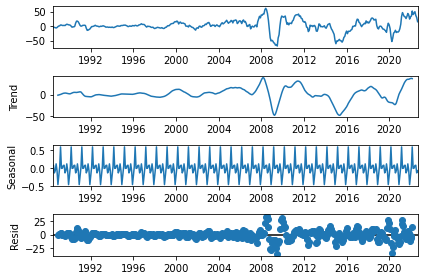

In [298]:
decomposed = seasonal_decompose(crude_dif_12)
decomposed.plot();
plt.show()

We observe that the magnitude of seasonality is reduced from a magnitude of 2.5 to 0.5

<AxesSubplot:xlabel='DATE'>

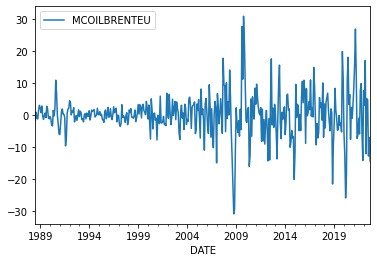

In [299]:
# still seasonality exist, so we do first level differencing

crude_dif_12_1 = crude.diff(12).diff(1).dropna()
crude_dif_12_1.plot()

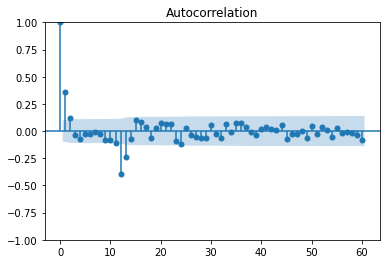

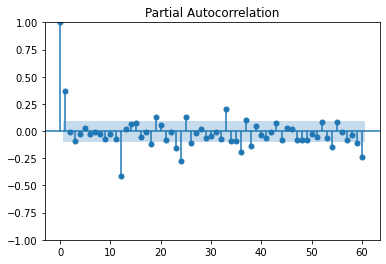

In [300]:
plot_acf(crude_dif_12_1, lags=60) 

plot_pacf(crude_dif_12_1, lags=60)
plt.show()

We can tell from the differenced series that p=2 and q=0 as we see a geometric pattern. The seasonal differencing is 1

In [301]:
import statsmodels.api as sm

In [302]:
sarima_model = sm.tsa.statespace.SARIMAX(crude, 
                       order=(2,1,0),
                       seasonal_order=(2,1,0,12))
model = sarima_model.fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       MCOILBRENTEU   No. Observations:                  424
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -1282.065
Date:                            Mon, 17 Oct 2022   AIC                           2574.130
Time:                                    03:00:19   BIC                           2594.223
Sample:                                06-01-1987   HQIC                          2582.079
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3401      0.035      9.612      0.000       0.271       0.409
ar.L2         -0.0185      0.037     -0.501      0.617      -0.091       0.054
ar.S.L12      -0.5702      0.036    -15.905      0.000      -0.640      -0.500
ar.S.L24      -0.3855      0.042     -9.265      0.000      -0.467      -0.304
sigma2        29.5409      1.383     21.355      0.000      26.830      32.252
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               141.98
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              16.61   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We observe in the above model that ar.L2 component is not significant so the model is invalid. And then we try the SARIMAX(2,1,1)(2,1,0,12)

In [303]:
sarima_model = sm.tsa.statespace.SARIMAX(crude, 
                       order=(2,1,1),
                       seasonal_order=(2,1,0,12))
model = sarima_model.fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        MCOILBRENTEU   No. Observations:                  424
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood               -1275.594
Date:                             Mon, 17 Oct 2022   AIC                           2563.187
Time:                                     03:00:26   BIC                           2587.299
Sample:                                 06-01-1987   HQIC                          2572.726
                                      - 09-01-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3100      0.030     44.254      0.000       1.252       1.368
ar.L2         -0.3618      0.032    -11.300      0.000      -0.425      -0.299
ma.L1         -0.9996      0.120     -8.339      0.000      -1.235      -0.765
ar.S.L12      -0.5502      0.039    -14.208      0.000      -0.626      -0.474
ar.S.L24      -0.3749      0.041     -9.123      0.000      -0.455      -0.294
sigma2        28.3981      3.513      8.083      0.000      21.512      35.284
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               118.30
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):              17.17   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Here we observe that the model is valid since all parametrs are significant i.e., P>z is less than 0.05

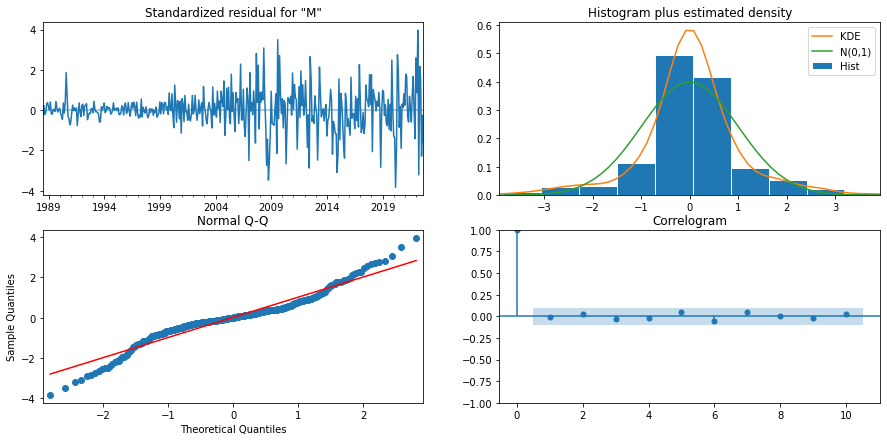

In [304]:
model.plot_diagnostics(figsize=(15,7)); plt.show()

We can observe that the residuals are normally distributed

In [305]:
# Splitting the data into training and testing
def split_data(df, test_split=0.3):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

train, test = split_data(crude, 0.3)   #70% train
print(train.tail())
print(test.tail())

            MCOILBRENTEU
DATE                    
2011-10-01        109.55
2011-11-01        110.77
2011-12-01        107.87
2012-01-01        110.69
2012-02-01        119.33
            MCOILBRENTEU
DATE                    
2022-05-01        113.34
2022-06-01        122.71
2022-07-01        111.93
2022-08-01        100.45
2022-09-01         89.76


In all the three models we are using 70% of data to train and 30% of data to test

In [306]:
test

,MCOILBRENTEU
DATE,
2012-03-01,125.45
2012-04-01,119.75
2012-05-01,110.34
2012-06-01,95.16
2012-07-01,102.62
...,...
2022-05-01,113.34
2022-06-01,122.71
2022-07-01,111.93


In [307]:
train

,MCOILBRENTEU
DATE,
1987-06-01,18.86
1987-07-01,19.86
1987-08-01,18.98
1987-09-01,18.31
1987-10-01,18.76
...,...
2011-10-01,109.55
2011-11-01,110.77
2011-12-01,107.87


In [308]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.
shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test'])
    plt.show()

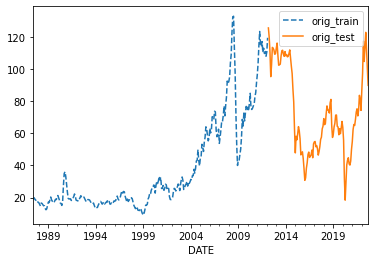

In [309]:
plot_forecast(model, '1987', train, test)

297 423


<AxesSubplot:>

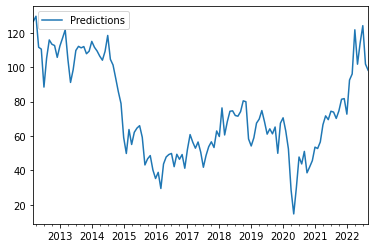

In [310]:
start = len(train)
end = len(train) + len(test) - 1
print(start, end)
predictions = model.predict(start, end,
                             typ = 'levels').rename("Predictions")
predictions.plot(legend = True)

[]

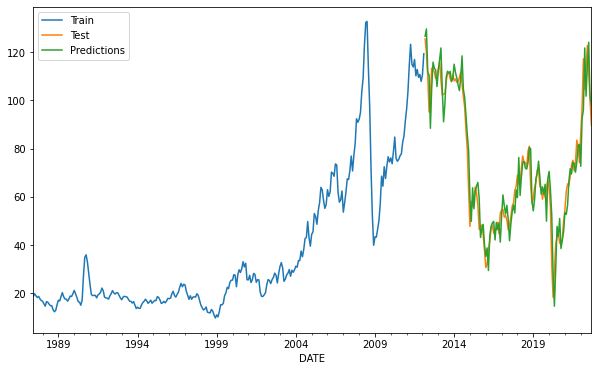

In [311]:
#forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
train['MCOILBRENTEU'].plot(legend=True, label='Train', figsize=(10,6))
test['MCOILBRENTEU'].plot(legend=True, label='Test')
predictions.plot(legend = True)
plt.plot()

In [312]:
test.head()

,MCOILBRENTEU
DATE,
2012-03-01,125.45
2012-04-01,119.75
2012-05-01,110.34
2012-06-01,95.16
2012-07-01,102.62


In [313]:
predictions.head()

2012-03-01    126.623864
2012-04-01    129.622731
2012-05-01    111.595733
2012-06-01    110.525883
2012-07-01     88.445102
Freq: MS, Name: Predictions, dtype: float64

In [314]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test,predictions))

7.164023697784183

In [315]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [316]:
#MAPE
mape(test,predictions)

47.69604034572938

In [317]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test,predictions)

51.32323554241335

In [318]:
#MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test,predictions)

5.483941973436738

The evaluation parameters are:
* RMSE- 7.16
* MAPE- 47.69
* MSE- 51.32
* MAE- 5.48

In [319]:
from pandas.tseries.offsets import DateOffset
pred_date=[crude.index[-1]+ DateOffset(months=x)for x in range(0,60)]

crude['Predictions'] = predictions
crude




,MCOILBRENTEU,Predictions
DATE,,
1987-06-01,18.86,NaN
1987-07-01,19.86,NaN
1987-08-01,18.98,NaN
1987-09-01,18.31,NaN
1987-10-01,18.76,NaN
...,...,...
2022-05-01,113.34,101.745732
2022-06-01,122.71,114.128745
2022-07-01,111.93,124.140016


In [320]:
crude['Predictions'].tail(36)

DATE
2019-10-01     65.230678
2019-11-01     49.945803
2019-12-01     67.462586
2020-01-01     70.581460
2020-02-01     62.934580
2020-03-01     52.491572
2020-04-01     28.681736
2020-05-01     14.710875
2020-06-01     30.073802
2020-07-01     47.787659
2020-08-01     43.759505
2020-09-01     51.056829
2020-10-01     38.607059
2020-11-01     42.025080
2020-12-01     45.668873
2021-01-01     53.525784
2021-02-01     52.740304
2021-03-01     56.562890
2021-04-01     66.582222
2021-05-01     71.704343
2021-06-01     69.513806
2021-07-01     74.398203
2021-08-01     73.903015
2021-09-01     70.228358
2021-10-01     74.632661
2021-11-01     81.361757
2021-12-01     81.750170
2022-01-01     72.703474
2022-02-01     92.537363
2022-03-01     96.074166
2022-04-01    121.738892
2022-05-01    101.745732
2022-06-01    114.128745
2022-07-01    124.140016
2022-08-01    101.806707
2022-09-01     98.227161
Name: Predictions, dtype: float64

In [321]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=crude.columns)
pred_date


,MCOILBRENTEU,Predictions
2022-10-01,NaN,NaN
2022-11-01,NaN,NaN
2022-12-01,NaN,NaN
2023-01-01,NaN,NaN
2023-02-01,NaN,NaN
2023-03-01,NaN,NaN
2023-04-01,NaN,NaN
2023-05-01,NaN,NaN
2023-06-01,NaN,NaN
2023-07-01,NaN,NaN


In [322]:
data=pd.concat([crude,pred_date])
data.shape  

(483, 2)

<AxesSubplot:>

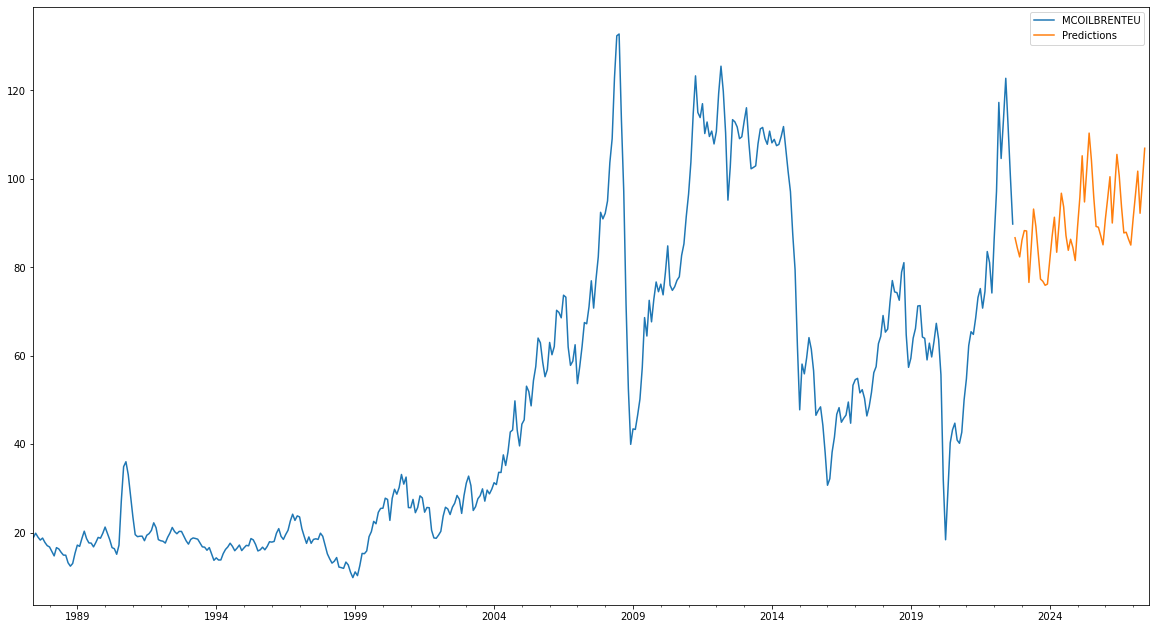

In [323]:
data['Predictions'] = model.predict(start = 424, end = 480, dynamic= True)  
data[['MCOILBRENTEU', 'Predictions']].plot(figsize=(20, 11))


Prediction plot for next 36 months

In [324]:
data[424:483]['Predictions']

2022-10-01     86.659770
2022-11-01     84.341296
2022-12-01     82.326083
2023-01-01     86.132813
2023-02-01     88.275089
2023-03-01     88.192882
2023-04-01     76.558101
2023-05-01     84.623980
2023-06-01     93.141942
2023-07-01     89.220519
2023-08-01     83.352476
2023-09-01     77.314794
2023-10-01     76.826374
2023-11-01     75.908517
2023-12-01     76.188962
2024-01-01     81.542759
2024-02-01     86.896682
2024-03-01     91.298437
2024-04-01     83.378886
2024-05-01     89.717841
2024-06-01     96.727039
2024-07-01     93.643184
2024-08-01     87.166269
2024-09-01     83.824992
2024-10-01     86.314205
2024-11-01     84.433209
2024-12-01     81.509605
2025-01-01     89.103990
2025-02-01     95.770971
2025-03-01    105.189431
2025-04-01     94.755689
2025-05-01    102.230171
2025-06-01    110.320477
2025-07-01    104.142014
2025-08-01     95.839057
2025-09-01     89.217754
2025-10-01     89.041640
2025-11-01     87.121775
2025-12-01     85.060517
2026-01-01     90.805544


# HOLTS WINTER METHOD

In [325]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hwmodel=ExponentialSmoothing(train.MCOILBRENTEU,trend='mul', seasonal='add', seasonal_periods=12) # specify the type of components we have to give
model=hwmodel.fit()
model.summary()

Dep. Variable:,MCOILBRENTEU,No. Observations:,297
Model:,ExponentialSmoothing,SSE,4894.557
Optimized:,True,AIC,864.238
Trend:,Multiplicative,BIC,923.337
Seasonal:,Additive,AICC,866.698
Seasonal Periods:,12,Date:,"Mon, 17 Oct 2022"
Box-Cox:,False,Time:,03:00:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.4553885,beta,True


In [326]:
test_pred=model.forecast(127)  #30% to test

In [327]:
test_pred

2012-03-01     125.319850
2012-04-01     131.157032
2012-05-01     135.942333
2012-06-01     141.091918
2012-07-01     146.351954
                 ...     
2022-05-01    1369.052721
2022-06-01    1388.938809
2022-07-01    1409.111461
2022-08-01    1428.740919
2022-09-01    1448.152585
Freq: MS, Length: 127, dtype: float64

In [328]:
test

,MCOILBRENTEU
DATE,
2012-03-01,125.45
2012-04-01,119.75
2012-05-01,110.34
2012-06-01,95.16
2012-07-01,102.62
...,...
2022-05-01,113.34
2022-06-01,122.71
2022-07-01,111.93


<AxesSubplot:xlabel='DATE'>

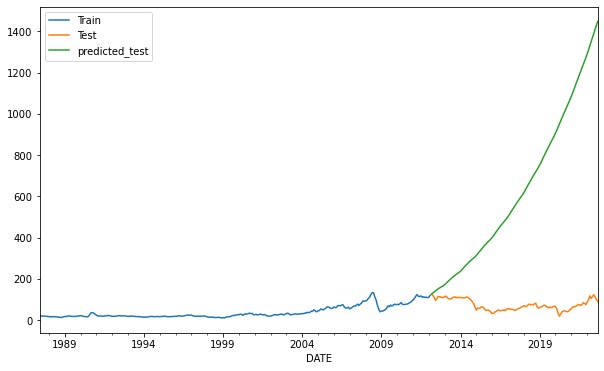

In [329]:
train['MCOILBRENTEU'].plot(legend=True, label='Train', figsize=(10,6))
test['MCOILBRENTEU'].plot(legend=True, label='Test')

test.count()
test_pred.plot(legend=True, label='predicted_test')

In [330]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test,test_pred))

675.6859180290925

In [331]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [332]:
#MAPE
mape(test,test_pred)

889.8091267438903

In [333]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(test,test_pred)

456551.4598228174

In [334]:
#MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test,test_pred)

555.4166952137057

The evaluation parameters are:
* RMSE- 675.6
* MAPE- 889.80
* MSE- 456551.4
* MAE- 555.4

In [335]:
final_model=ExponentialSmoothing(crude.MCOILBRENTEU,trend='mul', seasonal='add', seasonal_periods=12).fit()

In [336]:
pred=final_model.forecast(127)

In [337]:
pred

2022-10-01    89.040360
2022-11-01    87.361662
2022-12-01    86.121471
2023-01-01    86.420119
2023-02-01    87.334057
                ...    
2032-12-01    76.099789
2033-01-01    76.408464
2033-02-01    77.332419
2033-03-01    78.306963
2033-04-01    78.571452
Freq: MS, Length: 127, dtype: float64

<AxesSubplot:xlabel='DATE'>

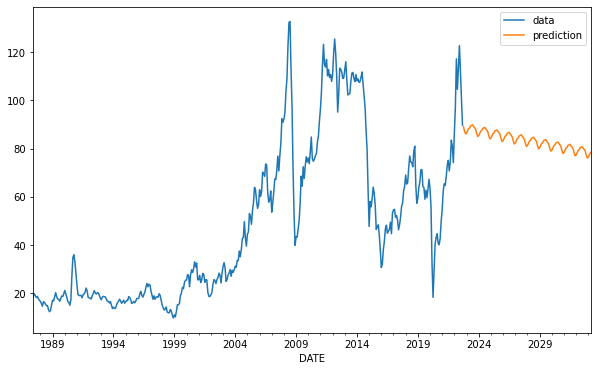

In [338]:
crude['MCOILBRENTEU'].plot(legend=True, label='data', figsize=(10,6))
pred.plot(legend=True, label='prediction')

The prediction plot is as shown above

# GARCH

In [339]:
from arch import arch_model


In [340]:
model_garch=arch_model(crude.MCOILBRENTEU[1:], mean="constant", vol="GARCH", p=1, q=1)
results_garch=model_garch.fit(update_freq=5)
results_garch.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 1835.3997714806526
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1746.0743877800205
Iteration:     15,   Func. Count:     88,   Neg. LLF: 2491.8981378435324
Iteration:     20,   Func. Count:    118,   Neg. LLF: 1717.5787641879892
Iteration:     25,   Func. Count:    142,   Neg. LLF: 1717.553748844442
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1717.5537491347338
            Iterations: 26
            Function evaluations: 142
            Gradient evaluations: 25


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           MCOILBRENTEU   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1717.55
Distribution:                  Normal   AIC:                           3443.11
Method:            Maximum Likelihood   BIC:                           3459.30
                                        No. Observations:                  423
Date:                Mon, Oct 17 2022   Df Residuals:                      422
Time:                        03:01:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            18.7203      0.252     74.278      0.000 [ 18.226, 19.214]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9534      0.274      3.482  4.981e-04   [  0.417,  1.490]
alpha[1]       0.9237  3.891e-02     23.739 1.414e-124   [  0.847,  1.000]
beta[1]        0.0763  3.424e-02      2.227  2.593e-02 [9.152e-03,  0.143]
==========================================================================

Covariance estimator: robust
"""

We observe that all the components are significant so the model is valid

# SIMPLE ARCH

In [341]:
model_arch=arch_model(crude.MCOILBRENTEU[1:])
results_arch=model_arch.fit()
results_arch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11897.388292340964
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1822.4844059359675
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1941.4279305968453
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1769.4685454380797
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1835.3997714806526
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1753.4377730172134
Iteration:      7,   Func. Count:     41,   Neg. LLF: 2052.405821047724
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1951.6588198478087
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1979.1596818316757
Iteration:     10,   Func. Count:     59,   Neg. LLF: 1746.0743877800205
Iteration:     11,   Func. Count:     64,   Neg. LLF: 1725.3304201757499
Iteration:     12,   Func. Count:     69,   Neg. LLF: 2184.5189353331853
Iteration:     13,   Func. Count:     76,   Neg. LLF: 2932.358004755124
Iteration:     14,   Func. Count:     82,   Neg. LLF:

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:           MCOILBRENTEU   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1717.55
Distribution:                  Normal   AIC:                           3443.11
Method:            Maximum Likelihood   BIC:                           3459.30
                                        No. Observations:                  423
Date:                Mon, Oct 17 2022   Df Residuals:                      422
Time:                        03:01:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            18.7203      0.252     74.278      0.000 [ 18.226, 19.214]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9534      0.274      3.482  4.981e-04   [  0.417,  1.490]
alpha[1]       0.9237  3.891e-02     23.739 1.414e-124   [  0.847,  1.000]
beta[1]        0.0763  3.424e-02      2.227  2.593e-02 [9.152e-03,  0.143]
==========================================================================

Covariance estimator: robust
"""

We observe that all components in the ARCH model are significant so the model is valid. Thus, there is volatity in the data

In [342]:
import arch

# a standard GARCH(1,1) model
garch = arch_model(crude.MCOILBRENTEU, vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()

# one-step out-of sample forecast
garch_forecast = garch_fitted.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11927.109975059546
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1855.0341952350268
Iteration:      3,   Func. Count:     18,   Neg. LLF: 1945.785742862766
Iteration:      4,   Func. Count:     25,   Neg. LLF: 1771.3140108869748
Iteration:      5,   Func. Count:     30,   Neg. LLF: 1795.4024892772704
Iteration:      6,   Func. Count:     36,   Neg. LLF: 1755.4816504197672
Iteration:      7,   Func. Count:     41,   Neg. LLF: 1985.885636889322
Iteration:      8,   Func. Count:     47,   Neg. LLF: 1918.7465453977024
Iteration:      9,   Func. Count:     53,   Neg. LLF: 1913.3702291682175
Iteration:     10,   Func. Count:     59,   Neg. LLF: 2118.8469704028685
Iteration:     11,   Func. Count:     66,   Neg. LLF: 1328354.8920720138
Iteration:     12,   Func. Count:     72,   Neg. LLF: 1827.827480786019
Iteration:     13,   Func. Count:     78,   Neg. LLF: 1835.663610800593
Iteration:     14,   Func. Count:     84,   Neg. LLF: 1

# LSTM

In [343]:
import numpy as np
import pandas as pd
crude = pd.read_csv('C:\\Users\\Nikitha Reddy\\Downloads\\MCOILBRENTEU.csv', 
                   parse_dates=['DATE'])
crude = crude.set_index('DATE')
df=crude
df

,MCOILBRENTEU
DATE,
1987-05-01,18.58
1987-06-01,18.86
1987-07-01,19.86
1987-08-01,18.98
1987-09-01,18.31
...,...
2022-05-01,113.34
2022-06-01,122.71
2022-07-01,111.93


In [344]:
df1=df.reset_index()['MCOILBRENTEU']

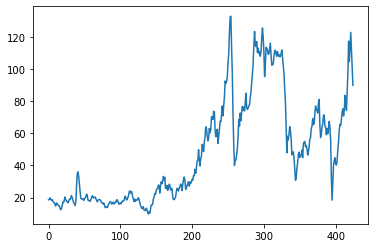

In [345]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [346]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [347]:
##splitting dataset into train and test split 

training_size=int(len(df1)*0.70)  #70% training
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [348]:
training_size,test_size

(297, 128)

In [349]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [350]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [351]:
print(X_train.shape), print(y_train.shape)

(266, 30)
(266,)


(None, None)

In [352]:
print(X_test.shape)
print(ytest.shape)

(97, 30)
(97,)


In [353]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [354]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [355]:
model=Sequential()
model.add(LSTM(60,return_sequences=True,input_shape=(30,1))) #stacking the layers
model.add(LSTM(60,return_sequences=True))
model.add(LSTM(60))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [356]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 60)            14880     
                                                                 
 lstm_4 (LSTM)               (None, 30, 60)            29040     
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dense_4 (Dense)             (None, 1)                 61        
                                                                 
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [357]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=15,verbose=1)

Epoch 1/20
18/18 [==============================] - 11s 157ms/step - loss: 0.0413 - val_loss: 0.0437
Epoch 2/20
18/18 [==============================] - 1s 71ms/step - loss: 0.0148 - val_loss: 0.0617
Epoch 3/20
18/18 [==============================] - 2s 107ms/step - loss: 0.0141 - val_loss: 0.0633
Epoch 4/20
18/18 [==============================] - 2s 105ms/step - loss: 0.0119 - val_loss: 0.0435
Epoch 5/20
18/18 [==============================] - 2s 105ms/step - loss: 0.0119 - val_loss: 0.0336
Epoch 6/20
18/18 [==============================] - 2s 85ms/step - loss: 0.0114 - val_loss: 0.0301
Epoch 7/20
18/18 [==============================] - 2s 107ms/step - loss: 0.0118 - val_loss: 0.0265
Epoch 8/20
18/18 [==============================] - 1s 72ms/step - loss: 0.0116 - val_loss: 0.0257
Epoch 9/20
18/18 [==============================] - 1s 60ms/step - loss: 0.0101 - val_loss: 0.0355
Epoch 10/20
18/18 [==============================] - 2s 99ms/step - loss: 0.0087 - val_loss: 0.0218
Epo

In [358]:
import tensorflow as tf

In [359]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

4/4 [==============================] - 0s 15ms/step


In [360]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [361]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

49.492688341303115

In [362]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

70.82958305789623

In [363]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [364]:
#MAPE
mape(ytest,test_predict)

19057.617077163468

In [365]:
#MSE
from sklearn.metrics import mean_squared_error
mean_squared_error(ytest,test_predict)

5016.829836155421

In [366]:
#MAE
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest,test_predict)

69.05374974236578

The evaluation parameters are:
* RMSE- 69.04
* MAPE- 18571.5
* MSE- 4767.2
* MAE- 67.29

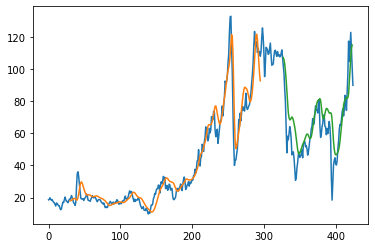

In [368]:
### Plotting 
# shift train predictions for plotting
look_back=30
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Prediction plot

In [369]:
len(test_data)

128

In [370]:
# Taking the last 30 data points 
x_input=test_data[98:].reshape(1,-1)
x_input.shape

(1, 30)

In [371]:
# Storing the values in a list. 
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [372]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
       # print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
      #  print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
       # print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        #print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)
len(lst_output)

[[0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022], [0.7224725484848022]]


30

In [373]:
day_new=np.arange(1,31)
day_pred=np.arange(31,61)

Prediction values

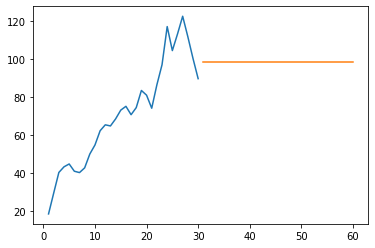

In [374]:
plt.plot(day_new,scaler.inverse_transform(df1[395:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

In [375]:
pred=scaler.inverse_transform(lst_output)
print(pred)

[[98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]
 [98.61187621]]


From all the above models, we select SARIMA model as it is giving us the best RMSE.

# THANK YOU!